# Covid-19 v České republice

_TODO:_
- automatizace přes papermill (https://github.com/nteract/papermill)
- pouštět každé ráno
- výsledek ukládat na github

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import json
import datetime as dt

plt.style.use('ggplot')

def autolabel(rects, ax, val_prec=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height!=height:height=0
        if val_prec == 0:
            height_str = f'{height:.0f}'
        elif val_prec == 1:
            height_str = f'{height:.1f}'            
        else:
            height_str = f'{height:.2f}'
        ax.annotate(height_str,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

with urllib.request.urlopen("https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.json") as url:
    data = json.loads(url.read().decode())


    df = pd.DataFrame(data['data'])
    df['datum'] = pd.to_datetime(df['datum'], errors='coerce')
    df['datum'] = df['datum'].dt.date
    
    display(df.tail())

,datum,kumulovany_pocet_nakazenych,kumulovany_pocet_vylecenych,kumulovany_pocet_umrti,kumulovany_pocet_provedenych_testu
93,2020-04-29,7579,3462,233,242384
94,2020-04-30,7682,3535,240,249644
95,2020-05-01,7737,3570,245,253987
96,2020-05-02,7755,3591,247,257881
97,2020-05-03,7781,3592,249,261548


In [2]:
# add daily counts + other params

df.rename(columns={'datum': 'date', 
                   'kumulovany_pocet_nakazenych': 'positive_total',
                  'kumulovany_pocet_vylecenych': 'recovered_total', 
                  'kumulovany_pocet_umrti': 'deceased_total',
                  'kumulovany_pocet_provedenych_testu': 'tested_total'}, inplace=True)

df['positive_daily'] = df['positive_total'] - df['positive_total'].shift(1)
df['recovered_daily'] = df['recovered_total'] - df['recovered_total'].shift(1)
df['deceased_daily'] = df['deceased_total'] - df['deceased_total'].shift(1)
df['tested_daily'] = df['tested_total'] - df['tested_total'].shift(1)

df['active'] = df['positive_total'] - df['recovered_total'] - df['deceased_total'] 


df['positive_increase']=0
#df = totalPositiveTests
df['positive_increase'] = (df['positive_total'] - \
                  df['positive_total'].shift(1)) / \
                  df['positive_total'].shift(1)
df['positive_increase_5d'] = (df['positive_increase'] + \
                              df['positive_increase'].shift(1) + \
                              df['positive_increase'].shift(2) + \
                              df['positive_increase'].shift(3) + \
                              df['positive_increase'].shift(4)) / 5

df['growth_factor'] = df['positive_daily'] / df['positive_daily'].shift(1)
df['ones'] = 1


In [3]:
df.tail()

,date,positive_total,recovered_total,deceased_total,tested_total,positive_daily,recovered_daily,deceased_daily,tested_daily,active,positive_increase,positive_increase_5d,growth_factor,ones
93,2020-04-29,7579,3462,233,242384,75.0,81.0,3.0,7319.0,3884,0.009995,0.008278,1.271186,1
94,2020-04-30,7682,3535,240,249644,103.0,73.0,7.0,7260.0,3907,0.013590,0.008824,1.373333,1
95,2020-05-01,7737,3570,245,253987,55.0,35.0,5.0,4343.0,3922,0.007160,0.008841,0.533981,1
96,2020-05-02,7755,3591,247,257881,18.0,21.0,2.0,3894.0,3917,0.002326,0.008199,0.327273,1
97,2020-05-03,7781,3592,249,261548,26.0,1.0,2.0,3667.0,3940,0.003353,0.007285,1.444444,1


## Vývoj počtu pozitivně testovaných

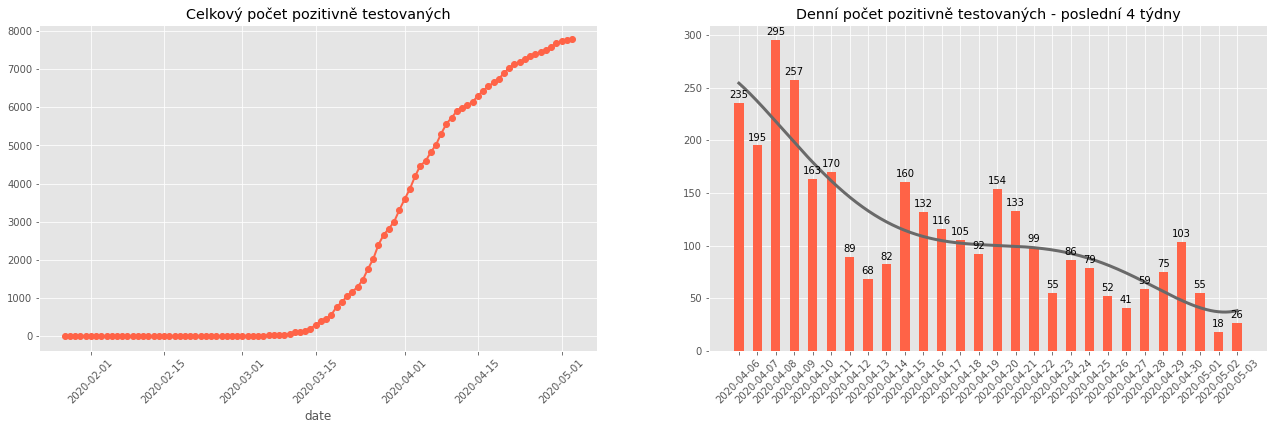

In [4]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date', 
                        y='positive_total', 
                        kind='line', 
                        style='tomato',
                        marker='o',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('positive_daily')])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet pozitivně testovaných - poslední 4 týdny')

plt.show()

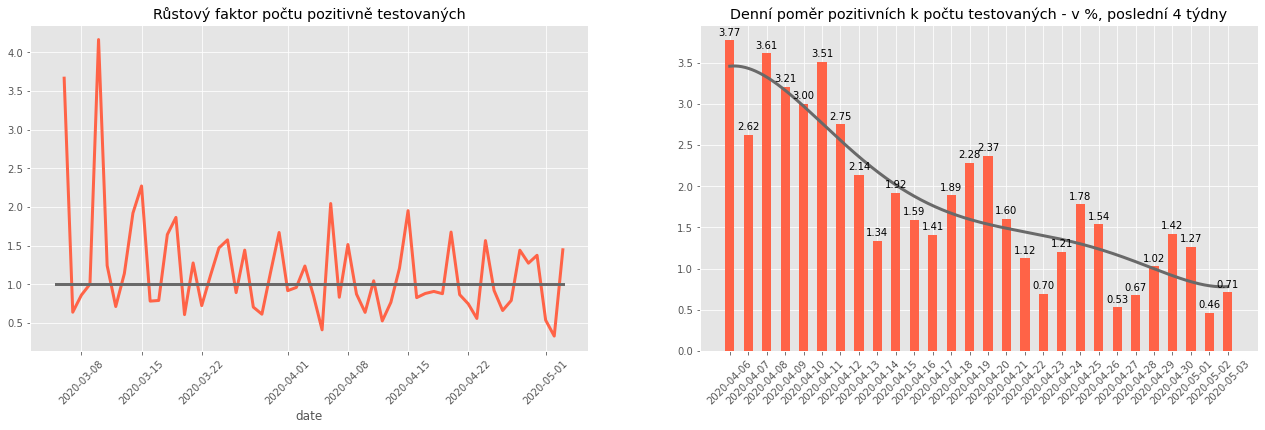

In [5]:
# interpoolace křivkou

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df[38:].plot(x='date', 
                    y=['growth_factor','ones'], 
                    kind='line',
                    style=['tomato', 'dimgray'],
                    linewidth=3,
                    #marker=['o',],
                    grid=True, 
                    legend=False,
                    ax=ax1,                        
                    title='Růstový faktor počtu pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(100*(df.iloc[-days_back:, df.columns.get_loc('positive_daily')]  / df.iloc[-days_back:, df.columns.get_loc('tested_daily')]))

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

#rects1 = ax2.bar(x, y, color='red')

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2, val_prec=2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní poměr pozitivních k počtu testovaných - v %, poslední 4 týdny')
plt.show()

## Vývoj počtu testovaných

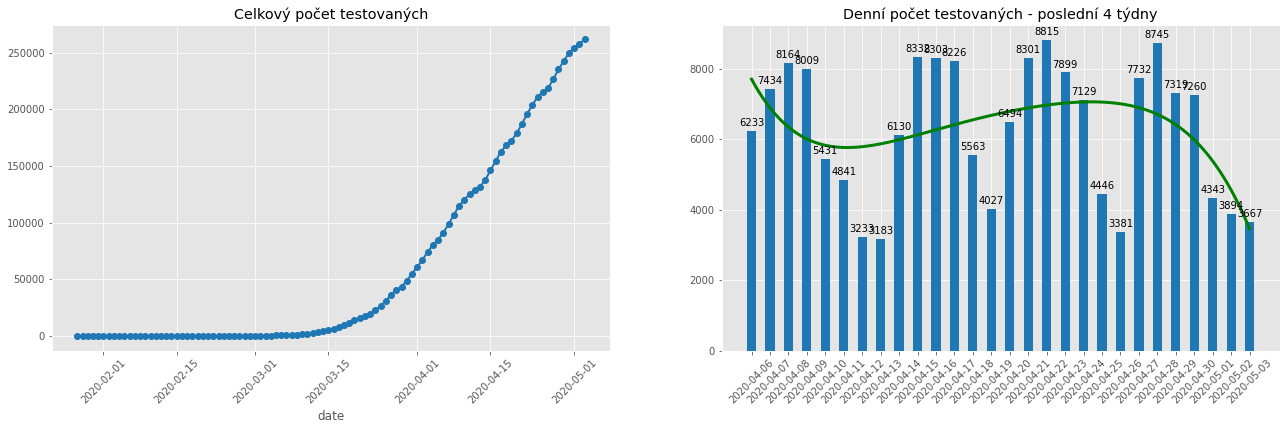

In [6]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date', 
                        y='tested_total', 
                        kind='line', 
                        style='tab:blue',
                        marker='o',
                        #color='royalblue',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('tested_daily')])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tab:blue')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'g-', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet testovaných - poslední 4 týdny')

plt.show()

## Vývoj průměrného denního nárůstu pozitivně testovaných 

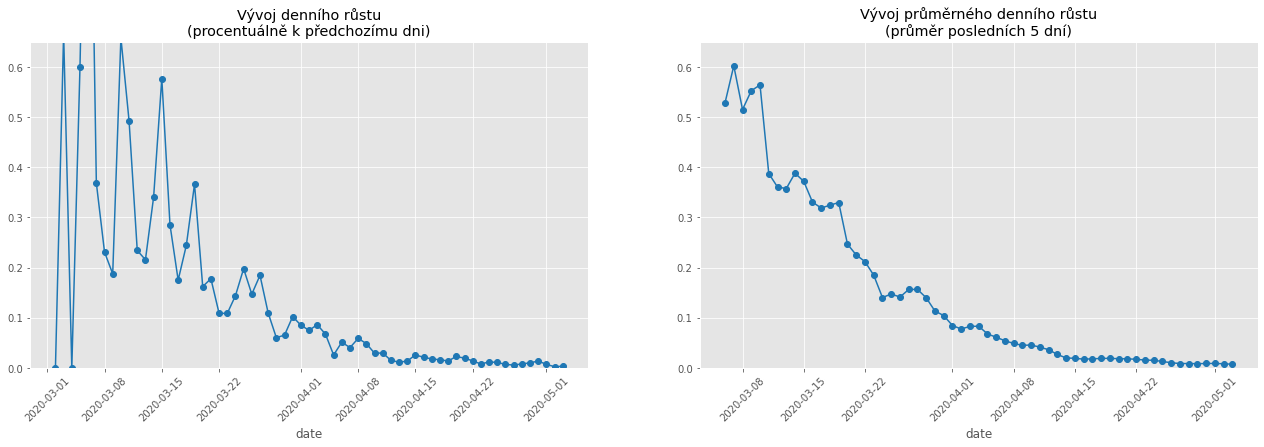

In [7]:

#totalPositiveTests.tail()

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date',
             y='positive_increase', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax1,
             title='Vývoj denního růstu\n(procentuálně k předchozímu dni)')
ax1.tick_params(axis="x", rotation=45) 

df.plot(x='date',
             y='positive_increase_5d', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax2,
             title='Vývoj průměrného denního růstu\n(průměr posledních 5 dní)')
ax2.tick_params(axis="x", rotation=45) 


plt.show()


# Počty uzdravených a zemřelých

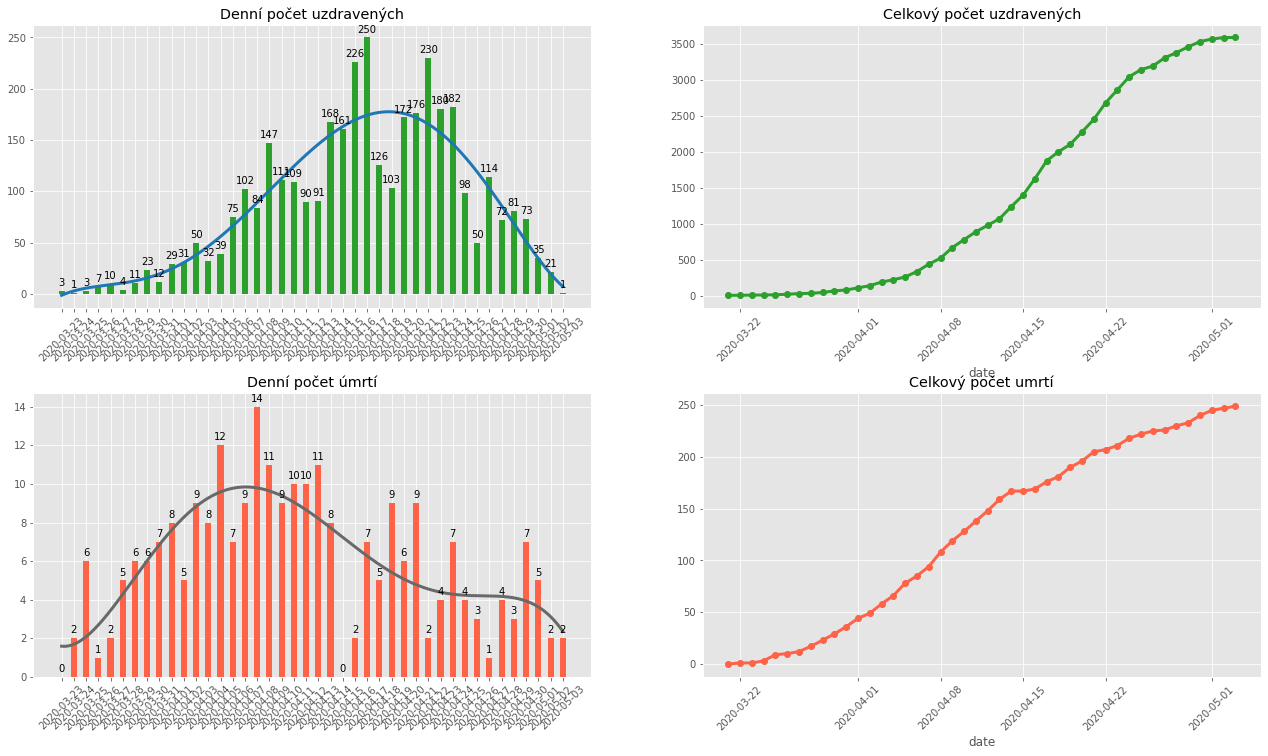

In [8]:
days_back=42

#print(f'Poslední den {df.iloc[-1, 0]} (neúplná data): {df.iloc[-1,6]} uzdravených, {df.iloc[-1,7]} zemřelých')
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('recovered_daily')]) ## 'recovered' -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title('Denní počet uzdravených')
plt.subplots_adjust(hspace=0.3)

df[df['date']>dt.date(2020, 3, 20)].plot(x='date', 
            y='recovered_total', 
            kind='line',
            linewidth=3,
            style='tab:green',
            marker='o',
            grid=True, 
            legend=False,
            ax=ax2,
            title='Celkový počet uzdravených')
ax2.tick_params(axis="x", rotation=45)

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('deceased_daily')])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax3.bar(x, y, width=.5, color='tomato')
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax3)

ax3.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax3.set_title('Denní počet úmrtí')
#plt.subplots_adjust(hspace=0.3)

df[df['date']>dt.date(2020, 3, 20)].plot(x='date', 
            y='deceased_total', 
            kind='line',
            linewidth=3,
            style='tomato',
            marker='o',
            grid=True,
            legend=False,
            ax=ax4,
            title='Celkový počet umrtí')
ax4.tick_params(axis="x", rotation=45)

plt.show()

# Celkový počet pozitivně testovaných vs. aktivní případy

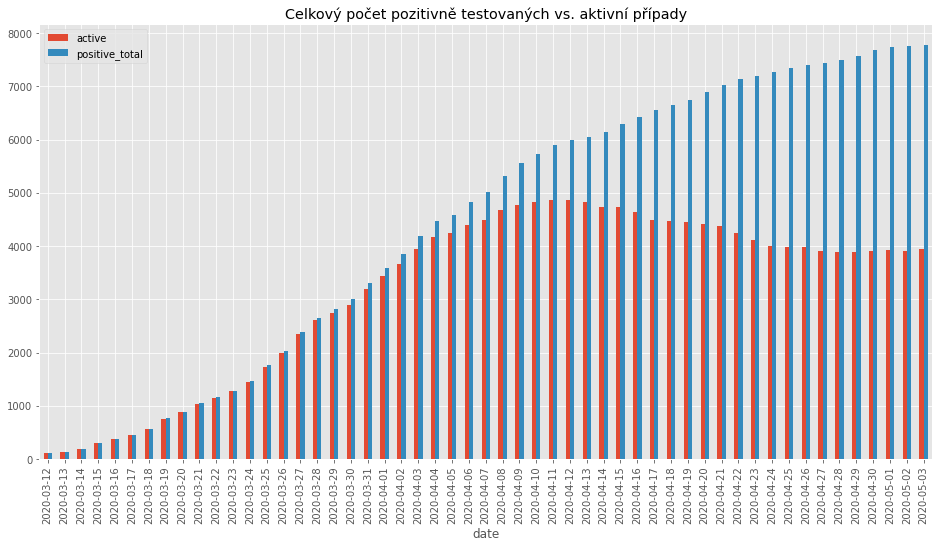

In [12]:
df[df['positive_total']>100].plot(x='date', 
            y=['active', 'positive_total'], 
            kind='bar', 
            figsize=(16, 8),
            grid=True, 
            title='Celkový počet pozitivně testovaných vs. aktivní případy')
plt.xticks(rotation=90)
plt.show()

In [10]:
# save data for later use
df.to_csv('data-' + df.iloc[-1, 0].strftime('%Y-%m-%d') + '.csv', index=False)